In [46]:
import os, csv
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras import layers, Input
from keras.optimizers import RMSprop, Adam
from sklearn.model_selection import train_test_split

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import csv
import os,random

from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM
from keras.layers.convolutional import Convolution1D
from keras.layers.core import Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import *
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

import datetime
now = datetime.datetime.now

In [47]:
def process(temp):
    min_len = 3000
    for i in range(11):
        j = 0
        while temp[j][i] != '' and j<len(temp)-1:
            j+=1
        min_len = min(min_len, j);
#     print(min_len)
    return temp[:min_len]

In [48]:
types = {'B_ID':8, 'E_ID':17, 'NE_ID':27, 'S_ID':10, 'P_ID':16}
x_val = []
x_id = []
for ids, vals in types.items():
    for i in range(1,vals+1):
        x_id.append(ids + str(i))
        try: 
            with open("../po-cf-ex-1-features/"+ids+str(i)+".csv", 'r') as f:
                temp = list(csv.reader(f, delimiter = ","))
            temp = process(temp)
            temp = np.asarray(temp)
            temp = temp.astype(np.float64)
        except:
            print("Problem in:", ids, i)
            continue
        x_val.append(temp.tolist())
x_val = np.asarray(sequence.pad_sequences(x_val, maxlen=600)).astype(np.float64)
print("x_val shape:", x_val.shape)

Problem in: E_ID 8
x_val shape: (77, 600, 11)


In [49]:
po_val = []
cf_val = []
for ids in x_id:
    try:
        df = pd.read_excel("../KiMoRe/"+ids+"/Es1/Label/ClinicalAssessment_"+ids+".xlsx")
    except:
        print("problem in: ", ids)
        continue
    df = np.array(df).reshape((16,))
    po_val.append(df[6])
    cf_val.append(df[11])
po_val = np.asarray(po_val).astype(np.float64)
cf_val = np.asarray(cf_val).astype(np.float64)
ts_val = po_val+cf_val
print("shape of CF: ", cf_val.shape)
print("shape of PO: ", po_val.shape)
print("shape of TS: ", ts_val.shape)
# print(po_val)
for i in range(len(ts_val)):
    if np.isnan(ts_val[i]):
        print(i)
print(ts_val)


problem in:  E_ID8
shape of CF:  (77,)
shape of PO:  (77,)
shape of TS:  (77,)
23
[41.         38.         28.21008112 33.3397327  44.33333333 45.33333333
 40.33333333 44.33333333 48.33333333 49.33333333 42.66666667 44.66666667
 46.         46.66666667 50.         50.         48.33333333 50.
 50.         46.33333333 44.         50.         47.                 nan
 39.66666667 41.         44.33333333 46.33333333 40.66666667 43.66666667
 42.         40.         42.         34.         46.         40.
 50.         50.         45.         47.         47.         38.
 50.         46.         46.         43.         41.         50.
 47.         49.         49.         27.         34.         44.
 26.         32.89508774 38.41075339 26.66666667 36.         26.33333333
 33.66666667 48.         27.         50.         14.         33.
 50.         22.         32.         40.         34.3081805  14.66666667
 35.66666667 36.66666667 36.         27.66666667 37.        ]


In [50]:
def jumble_up(val):
    return np.random.permutation(val)

In [51]:
indices = np.arange(len(ts_val))
indices = jumble_up(indices)
print(indices)
temp_x = x_val
temp_ts = ts_val
for i in range(len(ts_val)):
    x_val[i] = temp_x[indices[i]]
    ts_val[i] = temp_ts[indices[i]]

[30 21 42 35 10 37  5 25 28 58  0 57 75 45 56 55 16 59 63 13 53 44 36 29
 60 69 15 32 67 34 73 14 52 38 62 26 18 49 43 64 12 33 31  4 71 51  7 48
  8 20  3 65 47 17 46 19 68 66 11 40 41  2 50 22 70 27  1 24 76 54  6  9
 72 74 39 61 23]


In [52]:
x_val /= np.max(np.abs(x_val))
ts_val /= np.max(np.abs(ts_val))
x_train, x_test, y_train, y_test = train_test_split(x_val,ts_val, test_size=0.3)
print(y_train)

[0.82       0.65790175 0.53333333 1.         0.92       0.87333333
 0.64       0.52666667 1.         0.73333333 1.         1.
 0.94       0.87333333 1.         0.76821507 1.         0.76821507
 0.29333333 0.88       0.82       0.85333333 0.72       0.44
 0.55333333 0.9        0.28       1.         0.53333333 0.84
 0.82       0.55333333 0.84       0.65790175 0.54       0.55333333
 0.9        0.8        1.         0.84       0.72       0.72
 0.67333333 0.84       1.         0.81333333 1.         0.96666667
 0.68616361 0.66       0.92       0.88       1.        ]


In [53]:
timesteps = 600 
nr = 77   
n_dim = 11  
dropout_rate = 0.1

In [54]:
def Network():
    model = Sequential()

    model.add(Bidirectional(LSTM(100, recurrent_dropout = 0.5, return_sequences = True), input_shape = (timesteps,n_dim)))
    model.add(Dropout(0.2))

    model.add(Dense(30, activation = 'tanh'))
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(10, recurrent_dropout = 0.5)))
    model.add(Dropout(0.25))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam())
    
    # Early stopping if the validaton Loss does not decrease for 100 epochs
    early_stopping = EarlyStopping(monitor='val_loss', patience = 100)

    t = now()
    history = model.fit(x_train, y_train, batch_size=5, epochs=500, verbose=1, 
                     validation_data=(x_test, y_test),
                     callbacks = [early_stopping])
    print('Training time: %s' % (now() - t))
    
    # Plot the results
    plt.figure(1)
    plt.subplot(221)
    plt.plot(history.history['loss'])
    plt.title('Training Loss')
    plt.subplot(222)
    plt.plot(history.history['val_loss'])
    plt.title('Validation Loss')
    plt.tight_layout()
    plt.show()
    
    # Plot the prediction of the CNN model for the training and validation sets
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)

    plt.figure(figsize = (8,8))
    plt.subplot(2,1,1)
    plt.plot(pred_train,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
    plt.plot(y_train,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
    plt.ylim([-0.1,1.1])
    plt.title('Training Set',fontsize=18)
    plt.xlabel('Sequence Number',fontsize=16)
    plt.ylabel('Quality Scale',fontsize=16)
    plt.legend(loc=3, prop={'size':14}) # loc:position
    plt.subplot(2,1,2)
    plt.plot(pred_test,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
    plt.plot(y_test,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
    plt.title('Testing Set',fontsize=18)
    plt.ylim([-0.1,1.1])
    plt.xlabel('Sequence Number',fontsize=16)
    plt.ylabel('Quality Score',fontsize=16)
    plt.legend(loc=3, prop={'size':14}) # loc:position
    plt.tight_layout()
#     plt.savefig('../../Results/CNN_Vicon_Scores.png', dpi=300)
    plt.show()
    
    
    # Calculate the cumulative deviation and rms deviation for the validation set
    test_dev = abs(np.squeeze(pred_test)-y_test)
    # Cumulative deviation
    mean_abs_dev = np.mean(test_dev)
    # RMS deviation
    rms_dev = sqrt(mean_squared_error(pred_test, y_test))
    print('Mean absolute deviation:', mean_abs_dev)
    print('RMS deviation:', rms_dev)
    
    return mean_abs_dev, rms_dev

Epoch 1/500
11/11 [==============================] - 16s 949ms/step - loss: 0.6618 - val_loss: 0.5312
Epoch 2/500
11/11 [==============================] - 9s 823ms/step - loss: 0.5303 - val_loss: 0.5270
Epoch 3/500
11/11 [==============================] - 12s 1s/step - loss: 0.5270 - val_loss: 0.5161
Epoch 4/500
11/11 [==============================] - 11s 1s/step - loss: 0.5158 - val_loss: 0.5145
Epoch 5/500
11/11 [==============================] - 10s 897ms/step - loss: 0.5160 - val_loss: 0.5133
Epoch 6/500
11/11 [==============================] - 23s 2s/step - loss: 0.5306 - val_loss: 0.5000
Epoch 7/500
11/11 [==============================] - 11s 987ms/step - loss: 0.5115 - val_loss: 0.4967
Epoch 8/500
11/11 [==============================] - 11s 970ms/step - loss: 0.5377 - val_loss: 0.4983
Epoch 9/500
11/11 [==============================] - 12s 1s/step - loss: 0.5345 - val_loss: 0.5213
Epoch 10/500
11/11 [==============================] - 11s 972ms/step - loss: 0.5068 - val_loss:

11/11 [==============================] - 8s 747ms/step - loss: 0.5170 - val_loss: 0.5140
Epoch 82/500
11/11 [==============================] - 8s 759ms/step - loss: 0.5469 - val_loss: 0.5170
Epoch 83/500
11/11 [==============================] - 8s 745ms/step - loss: 0.5168 - val_loss: 0.5175
Epoch 84/500
11/11 [==============================] - 8s 737ms/step - loss: 0.5030 - val_loss: 0.5154
Epoch 85/500
11/11 [==============================] - 8s 780ms/step - loss: 0.4910 - val_loss: 0.5137
Epoch 86/500
11/11 [==============================] - 9s 821ms/step - loss: 0.5258 - val_loss: 0.5122
Epoch 87/500
11/11 [==============================] - 8s 740ms/step - loss: 0.5031 - val_loss: 0.5274
Epoch 88/500
11/11 [==============================] - 8s 723ms/step - loss: 0.5396 - val_loss: 0.5077
Epoch 89/500
11/11 [==============================] - 8s 736ms/step - loss: 0.5324 - val_loss: 0.5223
Epoch 90/500
11/11 [==============================] - 8s 735ms/step - loss: 0.5282 - val_loss: 

Epoch 161/500
11/11 [==============================] - 8s 731ms/step - loss: 0.4813 - val_loss: 0.4952
Epoch 162/500
11/11 [==============================] - 8s 735ms/step - loss: 0.4733 - val_loss: 0.5046
Epoch 163/500
11/11 [==============================] - 8s 742ms/step - loss: 0.5210 - val_loss: 0.5012
Epoch 164/500
11/11 [==============================] - 8s 727ms/step - loss: 0.4802 - val_loss: 0.4993
Epoch 165/500
11/11 [==============================] - 8s 739ms/step - loss: 0.5015 - val_loss: 0.5017
Epoch 166/500
11/11 [==============================] - 8s 725ms/step - loss: 0.4635 - val_loss: 0.4939
Epoch 167/500
11/11 [==============================] - 8s 753ms/step - loss: 0.5271 - val_loss: 0.4914
Epoch 168/500
11/11 [==============================] - 8s 718ms/step - loss: 0.5090 - val_loss: 0.5045
Epoch 169/500
11/11 [==============================] - 8s 740ms/step - loss: 0.4688 - val_loss: 0.5054
Epoch 170/500
11/11 [==============================] - 8s 739ms/step - lo

11/11 [==============================] - 8s 745ms/step - loss: 0.4848 - val_loss: 0.5103
Epoch 241/500
11/11 [==============================] - 8s 759ms/step - loss: 0.4809 - val_loss: 0.4867
Epoch 242/500
11/11 [==============================] - 8s 742ms/step - loss: 0.5028 - val_loss: 0.4911
Epoch 243/500
11/11 [==============================] - 8s 730ms/step - loss: 0.5128 - val_loss: 0.5102
Epoch 244/500
11/11 [==============================] - 8s 757ms/step - loss: 0.4464 - val_loss: 0.5164
Epoch 245/500
11/11 [==============================] - 8s 757ms/step - loss: 0.4830 - val_loss: 0.4996
Epoch 246/500
11/11 [==============================] - 8s 733ms/step - loss: 0.4963 - val_loss: 0.4948
Epoch 247/500
11/11 [==============================] - 8s 747ms/step - loss: 0.5022 - val_loss: 0.5063
Epoch 248/500
11/11 [==============================] - 8s 757ms/step - loss: 0.5037 - val_loss: 0.4932
Epoch 249/500
11/11 [==============================] - 8s 740ms/step - loss: 0.4449 - v

11/11 [==============================] - 8s 741ms/step - loss: 0.4587 - val_loss: 0.4889
Epoch 320/500
11/11 [==============================] - 8s 750ms/step - loss: 0.4799 - val_loss: 0.4914
Epoch 321/500
11/11 [==============================] - 8s 752ms/step - loss: 0.5124 - val_loss: 0.4962
Epoch 322/500
11/11 [==============================] - 8s 754ms/step - loss: 0.5454 - val_loss: 0.4904
Epoch 323/500
11/11 [==============================] - 8s 743ms/step - loss: 0.4670 - val_loss: 0.4851
Epoch 324/500
11/11 [==============================] - 8s 734ms/step - loss: 0.4933 - val_loss: 0.4820
Epoch 325/500
11/11 [==============================] - 8s 747ms/step - loss: 0.5148 - val_loss: 0.5138
Epoch 326/500
11/11 [==============================] - 8s 738ms/step - loss: 0.5056 - val_loss: 0.5127
Epoch 327/500
11/11 [==============================] - 8s 737ms/step - loss: 0.4367 - val_loss: 0.5014
Epoch 328/500
11/11 [==============================] - 8s 769ms/step - loss: 0.4675 - v

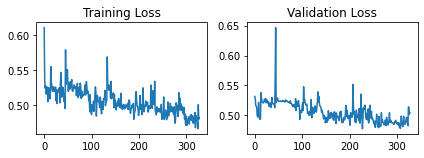

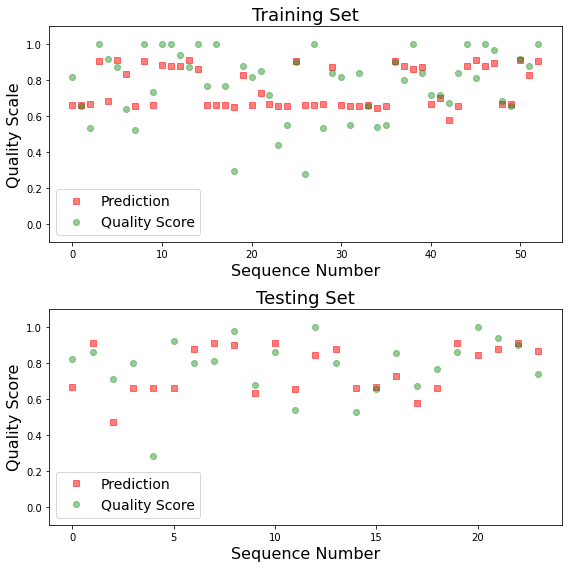

Mean absolute deviation: 0.1171509764603073
RMS deviation: 0.14282123358692048


In [55]:
Mean_abs_dev, RMS_dev  = Network()